##Importing Relevant Libraries

In [1]:
import os
import zipfile
import urllib.request
from pathlib import Path
import pandas as pd
import numpy as np
import librosa
import warnings
warnings.filterwarnings('ignore')
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib
import pickle
from datetime import datetime

In [2]:
def download_fma_dataset(data_dir="/content/fma_data", dataset_size='small'):
  data_dir = Path(data_dir)
  data_dir.mkdir(parents=True, exist_ok=True)

  urls = {
      'small': 'https://os.unil.cloud.switch.ch/fma/fma_small.zip',
      'medium': 'https://os.unil.cloud.switch.ch/fma/fma_medium.zip',
      'large': 'https://os.unil.cloud.switch.ch/fma/fma_large.zip',
      'metadata': 'https://os.unil.cloud.switch.ch/fma/fma_metadata.zip'
  }

  audio_dir = data_dir / f'fma_{dataset_size}'
  metadata_dir = data_dir / 'fma_metadata'

  # Download and extract if not exists
  for name, url in [(dataset_size, urls[dataset_size]), ('metadata', urls['metadata'])]:
    zip_path = data_dir/f'fma_{name}.zip'
    extract_dir = data_dir/f'fma_{name}'

    if extract_dir.exists() and any(extract_dir.iterdir()):
      print(f'Found existing directory {extract_dir}, skipping download.')
      continue
    if not zip_path.exists():
      print(f'Downloading {name} to {zip_path}...')
      urllib.request.urlretrieve(url, zip_path)

    print(f"Exctracting {zip_path} to {extract_dir}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(data_dir)
  return{
      'audio_dir': audio_dir,
      'metadata_dir': metadata_dir,
      'tracks_csv': metadata_dir / 'tracks.csv',
      'genres_csv': metadata_dir / 'genres.csv'
  }
if __name__ == '__main__':
  paths = download_fma_dataset(dataset_size='small')

Exctracting /content/fma_data/fma_small.zip to /content/fma_data/fma_small...
Exctracting /content/fma_data/fma_metadata.zip to /content/fma_data/fma_metadata...


## Exploratory Data Analysis

In [3]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
#Directories
DATA_DIR = Path('./data')
RAW_DATA_DIR = DATA_DIR / 'raw'
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'
MODEL_DIR = Path('./models')

for dir_path in [DATA_DIR, RAW_DATA_DIR, PROCESSED_DATA_DIR, TRAIN_DIR, TEST_DIR, MODEL_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

In [5]:
#Audio Parameters
SAMPLE_RATE = 22050
DURATION = 30
N_MFCC = 13

In [6]:
#model parameters
TEST_SIZE = 0.2
RANDOM_STATE = 42

In [7]:
# Loading tracks metadata
tracks = pd.read_csv(paths['metadata_dir'] / 'tracks.csv', index_col=0, header=[0, 1])
genres = pd.read_csv(paths['metadata_dir'] / 'genres.csv')

In [8]:
#total tracks
print(f"\nTotal tracks in FMA: {len(tracks)}")
print(f"\nDataset columns: {tracks.columns.tolist()[:10]}")


Total tracks in FMA: 106574

Dataset columns: [('album', 'comments'), ('album', 'date_created'), ('album', 'date_released'), ('album', 'engineer'), ('album', 'favorites'), ('album', 'id'), ('album', 'information'), ('album', 'listens'), ('album', 'producer'), ('album', 'tags')]


In [9]:
# filtering for hiphop
hiphop_tracks = tracks[tracks[('track', 'genre_top')] == 'Hip-Hop'].copy()
print(f"\nHip-Hop tracks: {len(hiphop_tracks)}")


Hip-Hop tracks: 3552


In [10]:
#one sample
print("\nSample Hip-Hop tracks:")
sample_cols = [('track', 'genre_top'), ('track', 'date_created'), ('album', 'title')]
print(hiphop_tracks[sample_cols].head())


Sample Hip-Hop tracks:
             track                                                album
         genre_top         date_created                           title
track_id                                                               
2          Hip-Hop  2008-11-26 01:48:12            AWOL - A Way Of Life
3          Hip-Hop  2008-11-26 01:48:14            AWOL - A Way Of Life
5          Hip-Hop  2008-11-26 01:48:20            AWOL - A Way Of Life
134        Hip-Hop  2008-11-26 01:43:19            AWOL - A Way Of Life
583        Hip-Hop  2008-11-26 02:06:04  WAR (If It Feels Good, Do It!)


In [11]:
#Create eras and visualize distributions
def assign_era(date_str):
    """Assign era based on release date"""
    if pd.isna(date_str):
        return None
    try:
        year = pd.to_datetime(date_str).year
        if year < 1995:
            return 'golden_age'
        elif year < 2005:
            return 'bling_era'
        elif year < 2015:
            return 'trap_rise'
        else:
            return 'modern'
    except:
        return None
# Add era labels
hiphop_tracks['era'] = hiphop_tracks[('track', 'date_created')].apply(assign_era)
hiphop_tracks = hiphop_tracks[hiphop_tracks['era'].notna()]

print(f"\nHip-Hop tracks with era labels: {len(hiphop_tracks)}")
print("\nEra distribution:")
print(hiphop_tracks['era'].value_counts().sort_index())


Hip-Hop tracks with era labels: 3552

Era distribution:
era
modern        850
trap_rise    2702
Name: count, dtype: int64


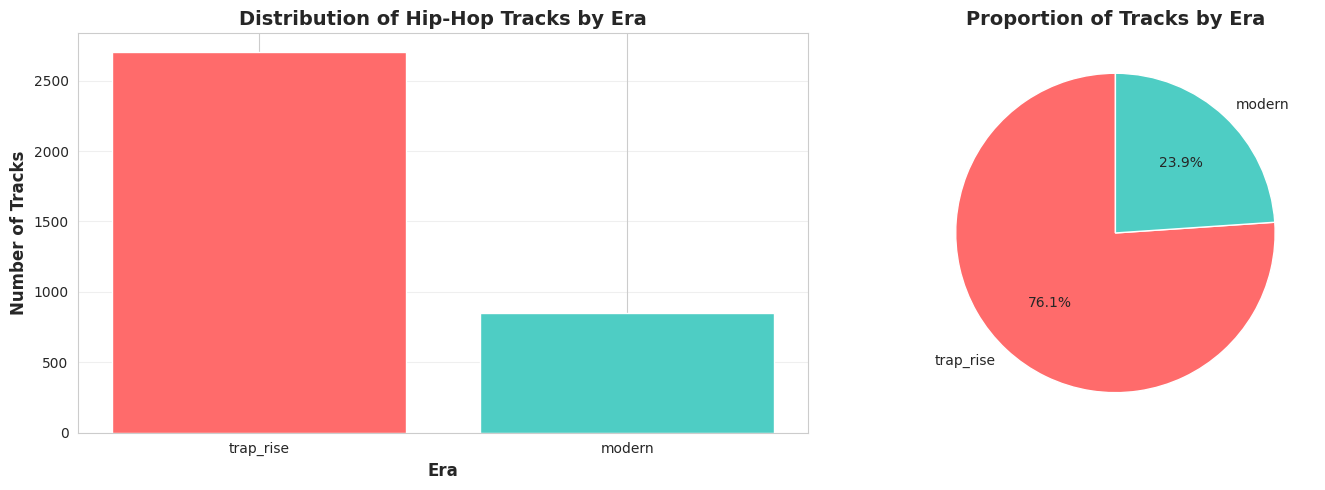

In [12]:
#Era Distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
#Count plot
era_counts = hiphop_tracks['era'].value_counts()
axes[0].bar(era_counts.index, era_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
axes[0].set_xlabel('Era', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Tracks', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Hip-Hop Tracks by Era', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

#Pie chart
axes[1].pie(era_counts.values, labels=era_counts.index, autopct='%1.1f%%',
            colors=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'], startangle=90)
axes[1].set_title('Proportion of Tracks by Era', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [13]:
#Organize Dataset by Era
def organize_dataset_by_era(hiphop_tracks, audio_dir, output_dir):
    """Organize audio files into train/test splits by era"""
    output_dir = Path(output_dir)

    # Train/test split (stratified by era)
    train_df, test_df = train_test_split(
        hiphop_tracks,
        test_size=TEST_SIZE,
        stratify=hiphop_tracks['era'],
        random_state=RANDOM_STATE
    )

    print(f"\nSplitting dataset:")
    print(f"  Training: {len(train_df)} tracks")
    print(f"  Testing: {len(test_df)} tracks")

    # Create era directories
    for split, df in [('train', train_df), ('test', test_df)]:
        for era_name in df['era'].unique():
            era_dir = output_dir / split / era_name
            era_dir.mkdir(parents=True, exist_ok=True)

    # Copy files
    for split, df in [('train', train_df), ('test', test_df)]:
        print(f"\nOrganizing {split} files...")
        copied = 0

        for idx, row in tqdm(df.iterrows(), total=len(df)):
            # Ensure era is a scalar string
            era = row['era'].item() if isinstance(row['era'], pd.Series) else row['era']
            track_id = str(idx).zfill(6)

            # FMA organizes files in subdirectories by first 3 digits
            src = Path(audio_dir / track_id[:3] / f'{track_id}.mp3')
            dst = Path(output_dir / split / era / f'{track_id}.mp3')

            if src.exists() and not dst.exists():
                # Make sure shutil is imported
                import shutil
                shutil.copy(src, dst)
                copied += 1

        print(f"Copied {copied} {split} files")

    return train_df, test_df

# Organize dataset
train_df, test_df = organize_dataset_by_era(hiphop_tracks, paths['audio_dir'], DATA_DIR)
print("\nDataset organization complete!")
print("\nFinal dataset structure:")
for split in ['train', 'test']:
    split_dir = DATA_DIR / split
    for era_dir in split_dir.iterdir():
        if era_dir.is_dir():
            count = len(list(era_dir.glob('*.mp3')))
            print(f"  {split}/{era_dir.name}: {count} files")


Splitting dataset:
  Training: 2841 tracks
  Testing: 711 tracks

Organizing train files...


100%|██████████| 2841/2841 [00:08<00:00, 353.00it/s]


Copied 793 train files

Organizing test files...


100%|██████████| 711/711 [00:01<00:00, 422.40it/s]

Copied 207 test files

Dataset organization complete!

Final dataset structure:
  train/modern: 215 files
  train/trap_rise: 578 files
  test/modern: 70 files
  test/trap_rise: 137 files


## Feature Extraction

In [14]:
from librosa.feature import spectral_bandwidth
def extract_audio_features(audio_path, sr=SAMPLE_RATE, duration=DURATION):
    """
    Extract features from an audio file.

    Returns:
        numpy array of 43 features
    """
    try:
      y, sr = librosa.load(audio_path, sr=sr, duration=duration)

      #MFCC features
      mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
      mfcc_mean = np.mean(mfcc, axis=1)
      mfcc_std = np.std(mfcc, axis=1)

      #spectral features
      spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
      spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
      spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
      zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))

      #rythmic features
      tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

      #12 chroma features
      chroma = librosa.feature.chroma_stft(y=y, sr=sr)
      chroma_mean = np.mean(chroma, axis=1)

      #combining all features
      features = np.concatenate([
          mfcc_mean,
          mfcc_std,
          np.array([spectral_centroid]).flatten(),
          np.array([spectral_rolloff]).flatten(),
          np.array([spectral_bandwidth]).flatten(),
          np.array([zero_crossing_rate]).flatten(),
          np.array([tempo]).flatten(),
          chroma_mean
      ])

      return features
    except Exception as e:
      print(f"Error processing {audio_path}: {e}")
      return None

def process_dataset(data_dir, split='train'):
  """process all audio files and extract features"""
  data_dir = Path(data_dir)
  features_list = []
  labels_list = []
  file_paths = []

  for era_dir in sorted((data_dir / split).iterdir()):
    if era_dir.is_dir():
      era = era_dir.name
      audio_files = list(era_dir.glob('*.mp3'))

      print(f"\n {era}: {len(audio_files)} files")

      for audio_file in tqdm(audio_files, desc=f" Extracting features"):
        features = extract_audio_features(audio_file)
        if features is not None:
          features_list.append(features)
          labels_list.append(era)
          file_paths.append(str(audio_file))

  #create dataframe
  feature_names = (
      [f'mfcc_mean_{i}' for i in range(N_MFCC)] +
      [f'mfcc_std_{i}' for i in range(N_MFCC)] +
      ['spectral_centroid', 'spectral_rolloff', 'spectral_bandwidth',
       'zero_crossing_rate', 'tempo'] +
      [f'chroma_{i}' for i in range(12)]
  )
  df = pd.DataFrame(features_list, columns=feature_names)
  df['era'] = labels_list
  df['file_path'] = file_paths

  print(f"\n Extracted features from {len(df)} files")
  print(f"  Feature dimensions: {df.shape}")

  return df

## Training

In [15]:
# process training data
train_features_df = process_dataset(DATA_DIR, split='train')


 modern: 215 files


 Extracting features: 100%|██████████| 215/215 [02:18<00:00,  1.55it/s]



 trap_rise: 578 files


 Extracting features: 100%|██████████| 578/578 [05:22<00:00,  1.79it/s]


 Extracted features from 793 files
  Feature dimensions: (793, 45)


In [16]:
# process test data
test_features_df = process_dataset(DATA_DIR, split='test')


 modern: 70 files


 Extracting features: 100%|██████████| 70/70 [00:38<00:00,  1.80it/s]



 trap_rise: 137 files


 Extracting features: 100%|██████████| 137/137 [01:15<00:00,  1.81it/s]


 Extracted features from 207 files
  Feature dimensions: (207, 45)


In [17]:
# saving processed features
train_features_df.to_csv(PROCESSED_DATA_DIR / 'train_features.csv', index=False)
test_features_df.to_csv(PROCESSED_DATA_DIR / 'test_features.csv', index=False)

## Feature Analysis and Visualization

In [18]:
# Faeture statistics
print(train_features_df.describe())

       mfcc_mean_0  mfcc_mean_1  mfcc_mean_2  mfcc_mean_3  mfcc_mean_4  \
count   793.000000   793.000000   793.000000   793.000000   793.000000   
mean    -91.862072    90.481631     7.315244    27.252123     6.535940   
std      67.689458    26.271329    19.727936    13.569482     9.722010   
min    -672.716553     7.714932   -72.325775   -62.476978   -29.947321   
25%    -125.298584    73.092491    -4.591154    19.365299     0.270370   
50%     -82.066856    89.122353     6.639377    26.807409     6.633816   
75%     -45.302845   103.943893    19.465115    35.168274    12.329077   
max      78.176598   198.646057   109.167694    79.505432    57.867107   

       mfcc_mean_5  mfcc_mean_6  mfcc_mean_7  mfcc_mean_8  mfcc_mean_9  ...  \
count   793.000000   793.000000   793.000000   793.000000   793.000000  ...   
mean     10.984908     0.582765     7.276928    -1.992034     4.950252  ...   
std       8.637924     7.078757     6.561851     6.342501     5.581361  ...   
min     -25.60057

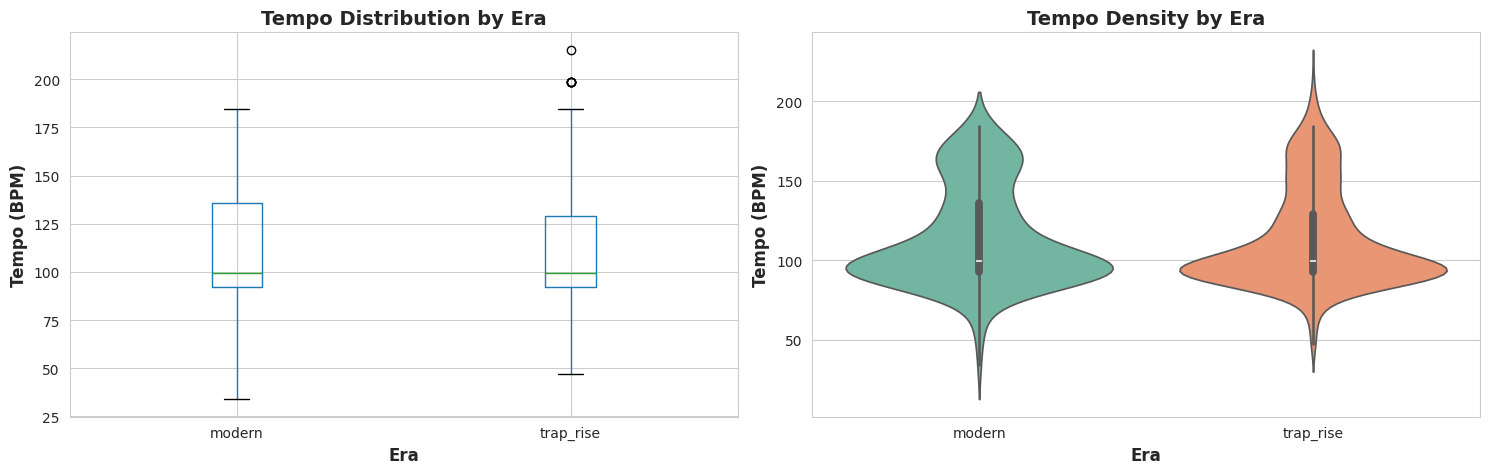

In [19]:
#Tempo Across Eras
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
#Box Plot
train_features_df.boxplot(column='tempo', by='era', ax=axes[0])
axes[0].set_xlabel('Era', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Tempo (BPM)', fontsize=12, fontweight='bold')
axes[0].set_title('Tempo Distribution by Era', fontsize=14, fontweight='bold')
axes[0].get_figure().suptitle('')
#Violin plot
sns.violinplot(data=train_features_df, x='era', y='tempo', ax=axes[1], palette='Set2')
axes[1].set_xlabel('Era', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Tempo (BPM)', fontsize=12, fontweight='bold')
axes[1].set_title('Tempo Density by Era', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [20]:
#Box Plot
train_features_df.boxplot(column='tempo', by='era', ax=axes[0])
axes[0].set_xlabel('Era', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Tempo (BPM)', fontsize=12, fontweight='bold')
axes[0].set_title('Tempo Distribution by Era', fontsize=14, fontweight='bold')
axes[0].get_figure().suptitle('')

Text(0.5, 0.98, '')

In [21]:
#Violin plot
sns.violinplot(data=train_features_df, x='era', y='tempo', ax=axes[1], palette='Set2')
axes[1].set_xlabel('Era', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Tempo (BPM)', fontsize=12, fontweight='bold')
axes[1].set_title('Tempo Density by Era', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

In [22]:
#Tempo by era
tempo_by_era = train_features_df.groupby('era')['tempo'].mean().sort_index()
for era, tempo in tempo_by_era.items():
    print(f"{era:15s}: {tempo:.1f} BPM")
print("\nTrap and Modern eras show faster tempos (140+ BPM) compared to")
print("Golden Age/Bling Era (90-110 BPM), reflecting evolution of production styles.")

modern         : 114.4 BPM
trap_rise      : 113.4 BPM

Trap and Modern eras show faster tempos (140+ BPM) compared to
Golden Age/Bling Era (90-110 BPM), reflecting evolution of production styles.


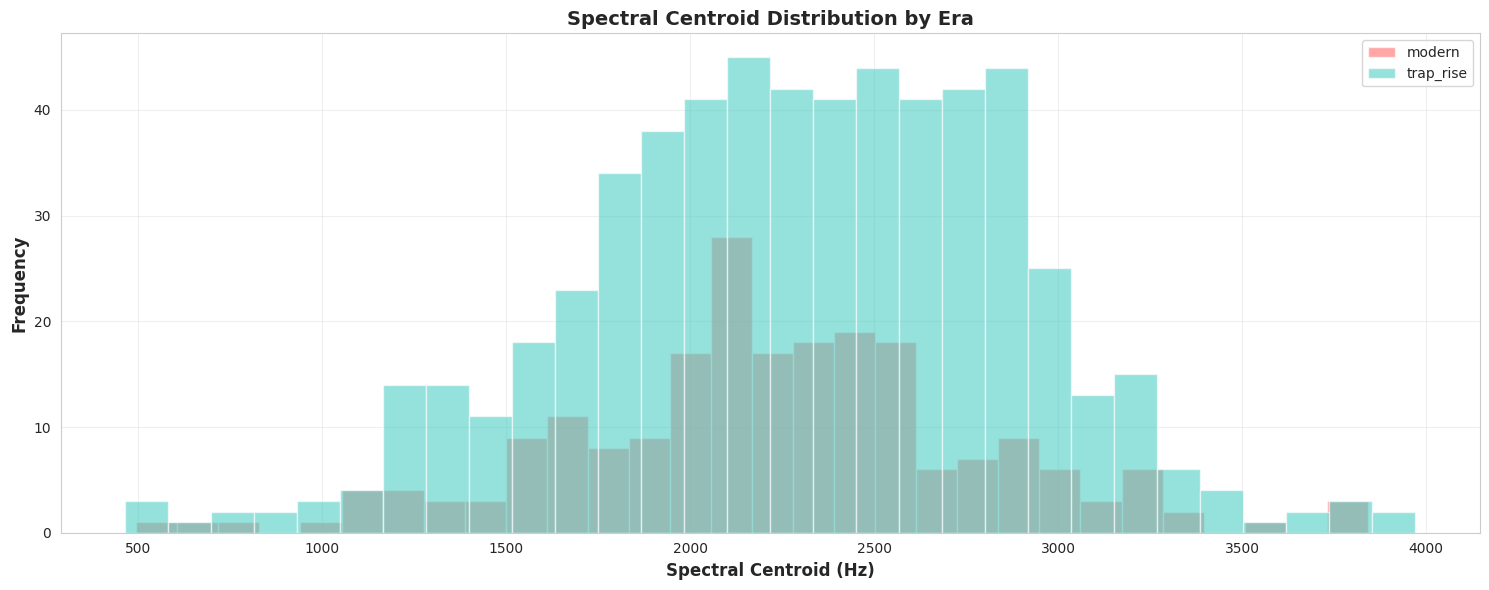

In [23]:
#Spectral centroid across eras
fig, ax = plt.subplots(figsize=(15, 6))

eras = train_features_df['era'].unique()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for era, color in zip(sorted(eras), colors):
    era_data = train_features_df[train_features_df['era'] == era]['spectral_centroid']
    ax.hist(era_data, bins=30, alpha=0.6, label=era, color=color)

ax.set_xlabel('Spectral Centroid (Hz)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Spectral Centroid Distribution by Era', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
spectral_by_era = train_features_df.groupby('era')['spectral_centroid'].mean().sort_index()
for era, centroid in spectral_by_era.items():
    print(f"{era:15s}: {centroid:.0f} Hz")
print("\nHigher spectral centroid in Modern era indicates brighter, more high-frequency")
print("content (hi-hats, synths) compared to bass-heavy Golden Age production.")

modern         : 2233 Hz
trap_rise      : 2298 Hz

Higher spectral centroid in Modern era indicates brighter, more high-frequency
content (hi-hats, synths) compared to bass-heavy Golden Age production.


## Data Preparation for training

In [25]:
#Separate features and labels
feature_columns = [col for col in train_features_df.columns
                   if col not in ['era', 'file_path']]

X_train = train_features_df[feature_columns].values
y_train = train_features_df['era'].values

X_test = test_features_df[feature_columns].values
y_test = test_features_df['era'].values

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Training set: (793, 43)
Test set: (207, 43)


In [26]:
#preprocessing
scaler = StandardScaler()
label_encoder = LabelEncoder()

In [27]:
#fit and transform
X_train_scaled = scaler.fit_transform(X_train)
y_train_encoded = label_encoder.fit_transform(y_train)

X_test_scaled = scaler.transform(X_test)
y_test_encoded = label_encoder.transform(y_test)

print(f"Classes: {label_encoder.classes_}")
print(f"Class distribution (train): {np.bincount(y_train_encoded)}")

Classes: ['modern' 'trap_rise']
Class distribution (train): [215 578]


## Training

In [28]:
# Initialize model
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

print("\nTraining Random Forest Classifier...")
print(f"  Estimators: {model.n_estimators}")
print(f"  Max depth: {model.max_depth}")


Training Random Forest Classifier...
  Estimators: 200
  Max depth: 20


In [29]:
#Train
model.fit(X_train_scaled, y_train_encoded)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.0s finished


RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42, verbose=1)

In [30]:
#Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
               feature  importance
16          mfcc_std_3    0.037274
19          mfcc_std_6    0.032452
6          mfcc_mean_6    0.031581
13          mfcc_std_0    0.029915
14          mfcc_std_1    0.028658
11        mfcc_mean_11    0.027464
2          mfcc_mean_2    0.027431
23         mfcc_std_10    0.027395
29  zero_crossing_rate    0.027352
20          mfcc_std_7    0.027296


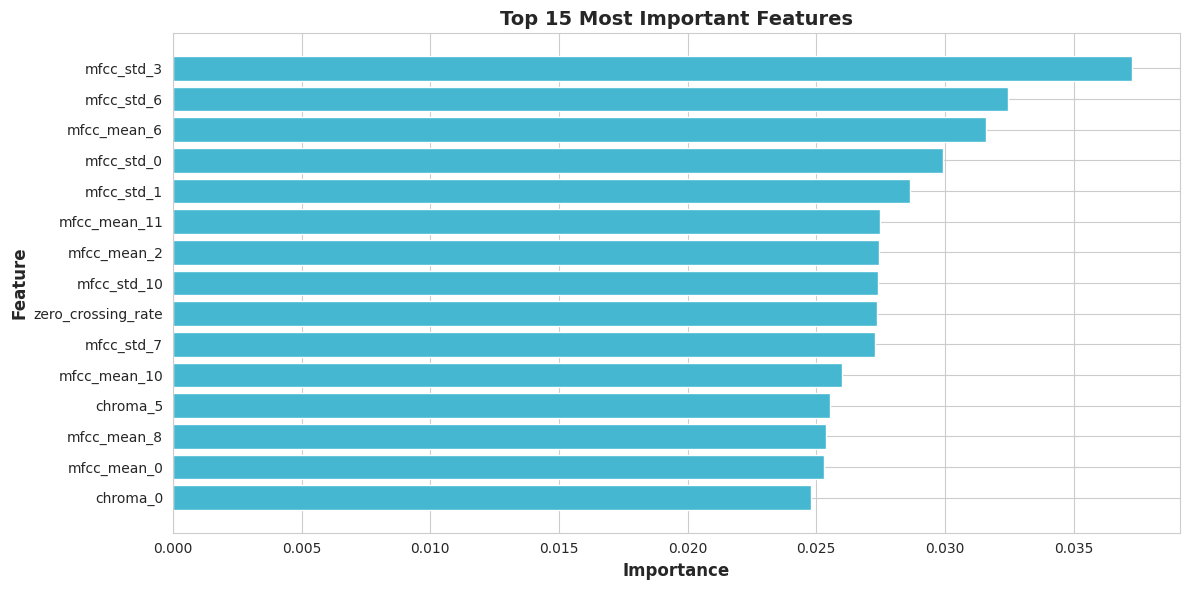

In [31]:
#feature importance visualization
fig, ax = plt.subplots(figsize=(12, 6))
top_features = feature_importance.head(15)
ax.barh(top_features['feature'], top_features['importance'], color='#45B7D1')
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Most Important Features', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

### Model Optimization — Early Stopping & Regularization
Below we add early stopping and tuned hyperparameters for improved performance.

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

# Random Forest hyperparameter grid
param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

# Grid search using log-loss as the scoring metric
grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring="neg_log_loss",   # optimize for log-loss
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit the optimized RF
grid.fit(X_train_scaled, y_train_encoded)

# Best model
model = grid.best_estimator_

print("Best Parameters:", grid.best_params_)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 400}


## Model evaluation

In [33]:
#Predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)

In [34]:
#metrics
accuracy = accuracy_score(y_test_encoded, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(
    y_test_encoded, y_pred, average='weighted'
)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

Accuracy:  0.6618
Precision: 0.6103
Recall:    0.6618
F1-Score:  0.5515


In [35]:
#Classification report
print("PER-CLASS METRICS")
print(classification_report(
    y_test_encoded,
    y_pred,
    target_names=label_encoder.classes_,
    digits=4
))

PER-CLASS METRICS
              precision    recall  f1-score   support

      modern     0.5000    0.0429    0.0789        70
   trap_rise     0.6667    0.9781    0.7929       137

    accuracy                         0.6618       207
   macro avg     0.5833    0.5105    0.4359       207
weighted avg     0.6103    0.6618    0.5515       207



In [36]:
#confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [37]:
#absolute counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            ax=axes[0])
axes[0].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=12, fontweight='bold')
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

Text(0.5, 1.0, 'Confusion Matrix (Counts)')

In [38]:
#normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            ax=axes[1])
axes[1].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=12, fontweight='bold')
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

## Save Model and Components

In [39]:
# Create timestamp version
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save model
model_path = MODEL_DIR / 'hiphop_era_classifier.pkl'
model_versioned_path = MODEL_DIR / f'hiphop_era_classifier_{timestamp}.pkl'
joblib.dump(model, model_path)
joblib.dump(model, model_versioned_path)

# Save preprocessing components
scaler_path = MODEL_DIR / 'scaler.pkl'
encoder_path = MODEL_DIR / 'label_encoder.pkl'
joblib.dump(scaler, scaler_path)
joblib.dump(label_encoder, encoder_path)

# Save metadata
metadata = {
    'timestamp': timestamp,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'n_train_samples': len(X_train),
    'n_test_samples': len(X_test),
    'n_features': len(feature_columns),
    'feature_names': feature_columns,
    'classes': label_encoder.classes_.tolist()
}

metadata_path = MODEL_DIR / 'model_metadata.pkl'
joblib.dump(metadata, metadata_path)

print(f"\nModel saved:")
print(f"  Latest: {model_path}")
print(f"  Versioned: {model_versioned_path}")
print(f"  Scaler: {scaler_path}")
print(f"  Encoder: {encoder_path}")
print(f"  Metadata: {metadata_path}")



Model saved:
  Latest: models/hiphop_era_classifier.pkl
  Versioned: models/hiphop_era_classifier_20251127_070705.pkl
  Scaler: models/scaler.pkl
  Encoder: models/label_encoder.pkl
  Metadata: models/model_metadata.pkl


## Prediction function and Demo

In [40]:
def predict_audio_era(audio_path, model, scaler, label_encoder):
    """
    Predict the era of a hip-hop track

    Args:
        audio_path: Path to audio file
        model: Trained classifier
        scaler: Fitted StandardScaler
        label_encoder: Fitted LabelEncoder

    Returns:
        dict with prediction and probabilities
    """
    # Extract features
    features = extract_audio_features(audio_path)

    if features is None:
        return None

    # Reshape and scale
    features_scaled = scaler.transform(features.reshape(1, -1))

    # Predict
    prediction_encoded = model.predict(features_scaled)[0]
    probabilities = model.predict_proba(features_scaled)[0]

    # Decode
    prediction = label_encoder.inverse_transform([prediction_encoded])[0]

    # Create result
    result = {
        'prediction': prediction,
        'confidence': float(probabilities[prediction_encoded]),
        'probabilities': {
            era: float(prob)
            for era, prob in zip(label_encoder.classes_, probabilities)
        }
    }

    return result

# Test on random samples from test set
print("\nTesting on random samples from test set:\n")

sample_indices = np.random.choice(len(test_features_df), size=5, replace=False)

for idx in sample_indices:
    audio_path = test_features_df.iloc[idx]['file_path']
    true_era = test_features_df.iloc[idx]['era']

    result = predict_audio_era(audio_path, model, scaler, label_encoder)

    if result:
        print(f"File: {Path(audio_path).name}")
        print(f"  True Era: {true_era}")
        print(f"  Predicted: {result['prediction']} ({result['confidence']:.2%} confidence)")
        print(f"  All probabilities:")
        for era, prob in sorted(result['probabilities'].items(), key=lambda x: x[1], reverse=True):
            print(f"    {era:15s}: {prob:.2%}")
        print()


Testing on random samples from test set:

File: 110086.mp3
  True Era: trap_rise
  Predicted: modern (51.80% confidence)
  All probabilities:
    modern         : 51.80%
    trap_rise      : 48.20%

File: 032882.mp3
  True Era: trap_rise
  Predicted: trap_rise (80.59% confidence)
  All probabilities:
    trap_rise      : 80.59%
    modern         : 19.41%

File: 109686.mp3
  True Era: trap_rise
  Predicted: trap_rise (79.46% confidence)
  All probabilities:
    trap_rise      : 79.46%
    modern         : 20.54%

File: 078851.mp3
  True Era: trap_rise
  Predicted: trap_rise (75.39% confidence)
  All probabilities:
    trap_rise      : 75.39%
    modern         : 24.61%

File: 010696.mp3
  True Era: trap_rise
  Predicted: trap_rise (65.13% confidence)
  All probabilities:
    trap_rise      : 65.13%
    modern         : 34.87%



### Live Prediction Demo
The following cell loads an audio file and performs the full prediction.

In [41]:
from google.colab import files
uploaded = files.upload()
audio_path = list(uploaded.keys())[0]
pred = predict_audio_era(audio_path, model, scaler, label_encoder)
print("Predicted class:", pred)

Saving 113031.mp3 to 113031.mp3
Predicted class: {'prediction': 'trap_rise', 'confidence': 0.8492965992340991, 'probabilities': {'modern': 0.1507034007659008, 'trap_rise': 0.8492965992340991}}


## Model Retraining Function

### Uploading New Training Data + Saving to Database
Below we implement:
1. File uploading
2. Saving uploaded file to MongoDB
3. Loading file from MongoDB for retraining


In [42]:
!pip install pymongo
from pymongo import MongoClient
import gridfs

client = MongoClient("mongodb://localhost:27017/")
db = client['audio_retrain_db']
fs = gridfs.GridFS(db)

def upload_training_file(file_path):
    with open(file_path, "rb") as f:
        file_id = fs.put(f, filename=os.path.basename(file_path))
        print("File uploaded to MongoDB with ID:", file_id)
    return file_id

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 26.1 MB/s eta 0:00:00


In [43]:
def load_file_from_db(file_id, output_path="retraining_uploaded.csv"):
    grid_out = fs.get(file_id)
    data = grid_out.read()
    with open(output_path, "wb") as f:
        f.write(data)
    print(f"File retrieved and written to: {output_path}")
    return output_path

## LightGBM with Early Stopping (Log-Loss Optimization)
Here we add a LightGBM model with **early stopping** and explicitly optimize for **log-loss**.
This serves as a strong alternative to the Random Forest model, allowing us to compare performance
and keep whichever model achieves the lower log-loss.

In [46]:
from lightgbm import LGBMClassifier, early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, brier_score_loss
from sklearn.preprocessing import label_binarize
import numpy as np

# Split the original training set into train/validation for early stopping
X_train_lgb, X_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(
    X_train_scaled, y_train_encoded,
    test_size=0.2,
    stratify=y_train_encoded,
    random_state=RANDOM_STATE
)

lgbm_model = LGBMClassifier(
    objective="multiclass",
    num_class=len(label_encoder.classes_),
    learning_rate=0.05,
    n_estimators=2000,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("Training LightGBM with early stopping (optimizing multi-class log-loss)...")
lgbm_model.fit(
    X_train_lgb, y_train_lgb,
    eval_set=[(X_valid_lgb, y_valid_lgb)],
    eval_metric="multi_logloss",
    callbacks=[early_stopping(100, verbose=50)]
)

# Use the best iteration automatically chosen by early stopping
y_proba_lgbm_test = lgbm_model.predict_proba(X_test_scaled)
lgbm_logloss = log_loss(y_test_encoded, y_proba_lgbm_test)

# Additional metrics for LightGBM (same as RF for fair comparison)
y_pred_lgbm = lgbm_model.predict(X_test_scaled)
lgbm_accuracy = accuracy_score(y_test_encoded, y_pred_lgbm)
lgbm_precision, lgbm_recall, lgbm_f1, _ = precision_recall_fscore_support(
    y_test_encoded, y_pred_lgbm, average="weighted"
)

# Per-class Brier scores for calibrated probabilities
n_classes = len(label_encoder.classes_)

# Manually create y_test_bin to ensure correct shape (n_samples, n_classes)
y_test_bin = np.zeros((len(y_test_encoded), n_classes))
for i, encoded_label in enumerate(y_test_encoded):
    y_test_bin[i, encoded_label] = 1

brier_per_class_lgbm = []
for i, cls in enumerate(label_encoder.classes_):
    bs = brier_score_loss(y_test_bin[:, i], y_proba_lgbm_test[:, i])
    brier_per_class_lgbm.append(bs)

lgbm_brier_mean = np.mean(brier_per_class_lgbm)

print(f"LightGBM Test Accuracy: {lgbm_accuracy:.4f}")
print(f"LightGBM Test Precision (weighted): {lgbm_precision:.4f}")
print(f"LightGBM Test Recall (weighted):    {lgbm_recall:.4f}")
print(f"LightGBM Test F1 (weighted):        {lgbm_f1:.4f}")
print(f"LightGBM Test Log-Loss:             {lgbm_logloss:.6f}")
print(f"LightGBM Mean per-class Brier:      {lgbm_brier_mean:.6f}")

Training LightGBM with early stopping (optimizing multi-class log-loss)...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8918
[LightGBM] [Info] Number of data points in the train set: 634, number of used features: 43
[LightGBM] [Info] Start training from score -1.304554
[LightGBM] [Info] Start training from score -0.316484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

## Model Comparison and Best Model Saving
Here we compare the **Random Forest** and **LightGBM** models on **log-loss** and
save the better one as the production model used for prediction and retraining.

In [47]:
# Compute Random Forest log-loss from existing predictions
# (y_pred_proba was computed earlier using the best RF model)
rf_logloss = log_loss(y_test_encoded, y_pred_proba)

print(f"Random Forest Test Log-Loss: {rf_logloss:.6f}")
print(f"LightGBM Test Log-Loss:      {lgbm_logloss:.6f}")

if lgbm_logloss < rf_logloss:
    best_model = lgbm_model
    best_model_name = "LightGBM (early stopping)"
    best_proba_test = y_proba_lgbm_test
else:
    best_model = model        # Random Forest from GridSearch
    best_model_name = "RandomForest (GridSearchCV)"
    best_proba_test = y_pred_proba

print(f"\nBest model selected based on log-loss: {best_model_name}")

# Recompute key metrics for the chosen best model
best_pred = best_model.predict(X_test_scaled)
best_accuracy = accuracy_score(y_test_encoded, best_pred)
best_precision, best_recall, best_f1, _ = precision_recall_fscore_support(
    y_test_encoded, best_pred, average="weighted"
)

best_logloss = log_loss(y_test_encoded, best_proba_test)

print(f"Best Model Accuracy:  {best_accuracy:.4f}")
print(f"Best Model Precision: {best_precision:.4f}")
print(f"Best Model Recall:    {best_recall:.4f}")
print(f"Best Model F1-Score:  {best_f1:.4f}")
print(f"Best Model Log-Loss:  {best_logloss:.6f}")

# Save the best model and updated metadata
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

model_path = MODEL_DIR / 'hiphop_era_classifier.pkl'
model_versioned_path = MODEL_DIR / f'hiphop_era_classifier_{timestamp}.pkl'
joblib.dump(best_model, model_path)
joblib.dump(best_model, model_versioned_path)

scaler_path = MODEL_DIR / 'scaler.pkl'
encoder_path = MODEL_DIR / 'label_encoder.pkl'
joblib.dump(scaler, scaler_path)
joblib.dump(label_encoder, encoder_path)

metadata = {
    'timestamp': timestamp,
    'best_model_name': best_model_name,
    'accuracy': best_accuracy,
    'precision': best_precision,
    'recall': best_recall,
    'f1_score': best_f1,
    'log_loss': best_logloss,
    'n_train_samples': len(X_train),
    'n_test_samples': len(X_test),
    'n_features': len(feature_columns),
    'feature_names': feature_columns,
    'classes': label_encoder.classes_.tolist()
}

metadata_path = MODEL_DIR / 'model_metadata.pkl'
joblib.dump(metadata, metadata_path)

print(f"\nBest model saved:")
print(f"  Latest: {model_path}")
print(f"  Versioned: {model_versioned_path}")
print(f"  Scaler: {scaler_path}")
print(f"  Encoder: {encoder_path}")
print(f"  Metadata: {metadata_path}")

Random Forest Test Log-Loss: 0.634892
LightGBM Test Log-Loss:      0.656972

Best model selected based on log-loss: RandomForest (GridSearchCV)
Best Model Accuracy:  0.6618
Best Model Precision: 0.6103
Best Model Recall:    0.6618
Best Model F1-Score:  0.5515
Best Model Log-Loss:  0.634892

Best model saved:
  Latest: models/hiphop_era_classifier.pkl
  Versioned: models/hiphop_era_classifier_20251127_071153.pkl
  Scaler: models/scaler.pkl
  Encoder: models/label_encoder.pkl
  Metadata: models/model_metadata.pkl


### Structured Prediction Demo on a Known Test Example
To clearly demonstrate the prediction process, we now:
1. Select a test sample where the model predicts correctly.
2. Show the input row.
3. Print both the **true label** and the **predicted label**, plus probabilities.

In [48]:
# Find a test example where the best model predicts correctly
correct_index = None
for i in range(len(X_test_scaled)):
    pred_i = best_model.predict(X_test_scaled[i].reshape(1, -1))[0]
    if pred_i == y_test_encoded[i]:
        correct_index = i
        break

if correct_index is None:
    correct_index = 0  # fallback, even if misclassified

x_example = X_test[correct_index]
x_example_scaled = X_test_scaled[correct_index].reshape(1, -1)
true_label_idx = y_test_encoded[correct_index]
true_label = label_encoder.inverse_transform([true_label_idx])[0]

pred_idx = best_model.predict(x_example_scaled)[0]
pred_label = label_encoder.inverse_transform([pred_idx])[0]
pred_proba = best_model.predict_proba(x_example_scaled)[0]

print("Example input features (first 10):")
print(x_example[:10])
print(f"\nTrue label:      {true_label}")
print(f"Predicted label: {pred_label}")
print(f"Probabilities by class:")
for cls, prob in zip(label_encoder.classes_, pred_proba):
    print(f"  {cls}: {prob:.3f}")

Example input features (first 10):
[-174.34214783   46.93081665    5.95502806   15.57199383   16.54411125
   14.24362659    4.27337694    9.74540615    5.38952923   15.84631062]

True label:      modern
Predicted label: modern
Probabilities by class:
  modern: 0.618
  trap_rise: 0.382


### Preprocessing and Retraining Using Uploaded Data
This section shows the **full retraining pipeline**:
1. Load a new training CSV file stored in MongoDB GridFS.
2. Apply the **same preprocessing** steps (feature selection, scaling, label encoding).
3. **Retrain** the currently best model using the new data in addition to the original training set.

Run `upload_training_file('path_to_new_training_csv.csv')` first to push a file into the database
and obtain a `file_id`, then pass that ID into `retrain_model_from_db(file_id)`.

In [49]:
def retrain_model_from_db(file_id):
    """Load a CSV from MongoDB, preprocess it, and retrain the best model.

    This uses the existing saved model as a *pre-trained* model by:
    - Loading its class and hyperparameters
    - Re-training a fresh instance of the same model type on combined old + new data
    """
    # 1. Load file from MongoDB GridFS
    csv_path = load_file_from_db(file_id)
    new_df = pd.read_csv(csv_path)

    print("New data shape:", new_df.shape)
    print("New data preview:")
    display(new_df.head())

    # 2. Ensure columns match expected training schema
    missing_cols = [c for c in feature_columns + ['era'] if c not in new_df.columns]
    if missing_cols:
        raise ValueError(f"New data is missing required columns: {missing_cols}")

    new_X = new_df[feature_columns].values
    new_y = new_df['era'].values

    # 3. Load existing preprocessing and base model
    scaler_path = MODEL_DIR / 'scaler.pkl'
    encoder_path = MODEL_DIR / 'label_encoder.pkl'
    model_path = MODEL_DIR / 'hiphop_era_classifier.pkl'

    existing_scaler = joblib.load(scaler_path)
    existing_encoder = joblib.load(encoder_path)
    base_model = joblib.load(model_path)

    # 4. Transform new data using existing scaler/encoder
    new_X_scaled = existing_scaler.transform(new_X)
    new_y_encoded = existing_encoder.transform(new_y)

    # 5. Combine with original training data
    X_combined = np.vstack([X_train_scaled, new_X_scaled])
    y_combined = np.concatenate([y_train_encoded, new_y_encoded])

    # 6. Recreate a fresh model of the same type with the same hyperparameters
    ModelClass = base_model.__class__
    params = base_model.get_params()
    retrained_model = ModelClass(**params)

    print("\nRetraining model on combined dataset...")
    retrained_model.fit(X_combined, y_combined)

    # 7. Quick evaluation on the held-out test set
    y_retrain_proba = retrained_model.predict_proba(X_test_scaled)
    retrain_logloss = log_loss(y_test_encoded, y_retrain_proba)
    print(f"Retrained model log-loss on test set: {retrain_logloss:.6f}")

    # 8. Save the retrained model back to disk (for future predictions)
    joblib.dump(retrained_model, model_path)
    print("Retrained model saved to:", model_path)

    return retrained_model

# Example usage (uncomment and set file_id):
# new_file_id = upload_training_file('path_to_new_training_csv.csv')
# retrained_model = retrain_model_from_db(new_file_id)